In [3]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [4]:
# 读入数据
data  = []

#使用with语句优势：1.自动关闭文件句柄；2.自动显示（处理）文件读取数据异常
with open("arxiv-metadata-oai-2019.json", 'r') as f: 
    for idx, line in enumerate(f): 
        
        # 读取前100行，如果读取所有数据需要8G内存
        if idx >= 100:
            break
        
        data.append(json.loads(line))
        
data = pd.DataFrame(data) #将list变为dataframe格式，方便使用pandas进行分析
data.shape #显示数据大小

(100, 14)

In [5]:
data.columns #列标签

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')

In [6]:
#行数
data.index

RangeIndex(start=0, stop=100, step=1)

In [7]:
data.head() #显示数据的前五行

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0297,Sung-Chul Yoon,"Sung-Chul Yoon, Philipp Podsiadlowski and Step...",Remnant evolution after a carbon-oxygen white ...,"15 pages, 15 figures, 3 tables, submitted to M...",None,10.1111/j.1365-2966.2007.12161.x,None,astro-ph,None,We systematically explore the evolution of t...,"[{'version': 'v1', 'created': 'Tue, 3 Apr 2007...",2019-08-19,"[[Yoon, Sung-Chul, ], [Podsiadlowski, Philipp,..."
1,0704.0342,Patrice Ntumba Pungu,B. Dugmore and PP. Ntumba,Cofibrations in the Category of Frolicher Spac...,27 pages,None,None,None,math.AT,None,Cofibrations are defined in the category of ...,"[{'version': 'v1', 'created': 'Tue, 3 Apr 2007...",2019-08-19,"[[Dugmore, B., ], [Ntumba, PP., ]]"
2,0704.0360,Zaqarashvili,T.V. Zaqarashvili and K Murawski,Torsional oscillations of longitudinally inhom...,"6 pages, 3 figures, accepted in A&A",None,10.1051/0004-6361:20077246,None,astro-ph,None,We explore the effect of an inhomogeneous ma...,"[{'version': 'v1', 'created': 'Tue, 3 Apr 2007...",2019-08-19,"[[Zaqarashvili, T. V., ], [Murawski, K, ]]"
3,0704.0525,"Sezgin Ayg\""un","Sezgin Aygun, Ismail Tarhan, Husnu Baysal",On the Energy-Momentum Problem in Static Einst...,This submission has been withdrawn by arXiv ad...,"Chin.Phys.Lett.24:355-358,2007",10.1088/0256-307X/24/2/015,None,gr-qc,None,This paper has been removed by arXiv adminis...,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007...",2019-10-21,"[[Aygun, Sezgin, ], [Tarhan, Ismail, ], [Baysa..."
4,0704.0535,Antonio Pipino,"Antonio Pipino (1,3), Thomas H. Puzia (2,4), a...",The Formation of Globular Cluster Systems in M...,"32 pages (referee format), 9 figures, ApJ acce...","Astrophys.J.665:295-305,2007",10.1086/519546,None,astro-ph,None,The most massive elliptical galaxies show a ...,"[{'version': 'v1', 'created': 'Wed, 4 Apr 2007...",2019-08-19,"[[Pipino, Antonio, ], [Puzia, Thomas H., ], [M..."


In [9]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-2019.json', ['id', 'categories','authors', 'update_date'])

KeyError: 'categories'

In [10]:
data["categories"].describe()

count          100
unique          31
top       astro-ph
freq            46
Name: categories, dtype: object

In [11]:
data["id"].describe()

count           100
unique          100
top       0705.1906
freq              1
Name: id, dtype: object

In [13]:
data["authors"].describe()

count                            100
unique                           100
top       David Bailin and Alex Love
freq                               1
Name: authors, dtype: object

In [14]:
#统计论文发布的月份
data["months"] = data["update_date"].apply(lambda x: re.findall('-[0-9][0-9]-',str(x)))
data['months'] = data['months'].apply(lambda x: str(x[0].replace('-', '')))
data["months"].describe()

count     100
unique      9
top        08
freq       75
Name: months, dtype: object

In [15]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url) #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags

#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})

#按照 "group_name" 进行分组，在组内使用 "archive_name" 进行排序
df_taxonomy.groupby(["group_name","archive_name"])
df_taxonomy

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."
3,Computer Science,Computer Science,Computer Science,"Computational Engineering, Finance, and Science",cs.CE,Covers applications of computer science to the...
4,Computer Science,Computer Science,Computer Science,Computational Geometry,cs.CG,Roughly includes material in ACM Subject Class...
...,...,...,...,...,...,...
150,Statistics,Statistics,Statistics,Computation,stat.CO,"Algorithms, Simulation, Visualization"
151,Statistics,Statistics,Statistics,Methodology,stat.ME,"Design, Surveys, Model Selection, Multiple Tes..."
152,Statistics,Statistics,Statistics,Machine Learning,stat.ML,"Covers machine learning papers (supervised, un..."
153,Statistics,Statistics,Statistics,Other Statistics,stat.OT,Work in statistics that does not fit into the ...


In [16]:
#总共有8大类
df_taxonomy["group_name"].describe()

count         155
unique          8
top       Physics
freq           51
Name: group_name, dtype: object

In [17]:
df_taxonomy["sum"] = 0
df = df_taxonomy.groupby("group_name").agg({"sum":"count"}).sort_values(by="sum",ascending=False).reset_index()
df

,group_name,sum
0,Physics,51
1,Computer Science,40
2,Mathematics,32
3,Quantitative Biology,10
4,Quantitative Finance,9
5,Statistics,6
6,Electrical Engineering and Systems Science,4
7,Economics,3


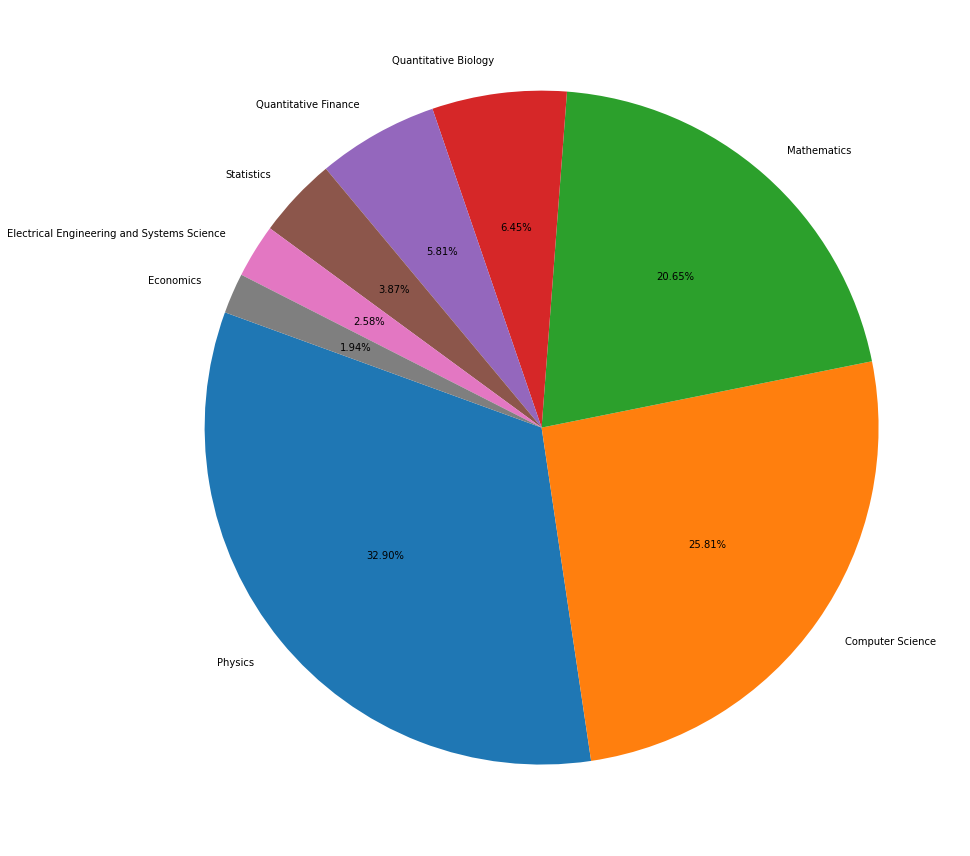

In [18]:
fig = plt.figure(figsize=(15,12))
plt.pie(df["sum"],  labels=df["group_name"], autopct='%1.2f%%', startangle=160)
plt.tight_layout()
plt.show()

In [19]:
data['categories'] = data['categories'].apply(lambda x: x.split(' ')[0])
data['categories'] = data['categories'].apply(lambda x: x.split('.')[0])
data["sum"] = 0
df2 = data.groupby("categories").agg({"sum":"count"}).sort_values(by="sum",ascending=False).reset_index()
df2

,categories,sum
0,astro-ph,46
1,math,17
2,hep-ex,13
3,nucl-ex,7
4,math-ph,4
5,quant-ph,3
6,cond-mat,2
7,cs,2
8,gr-qc,2
9,hep-th,2


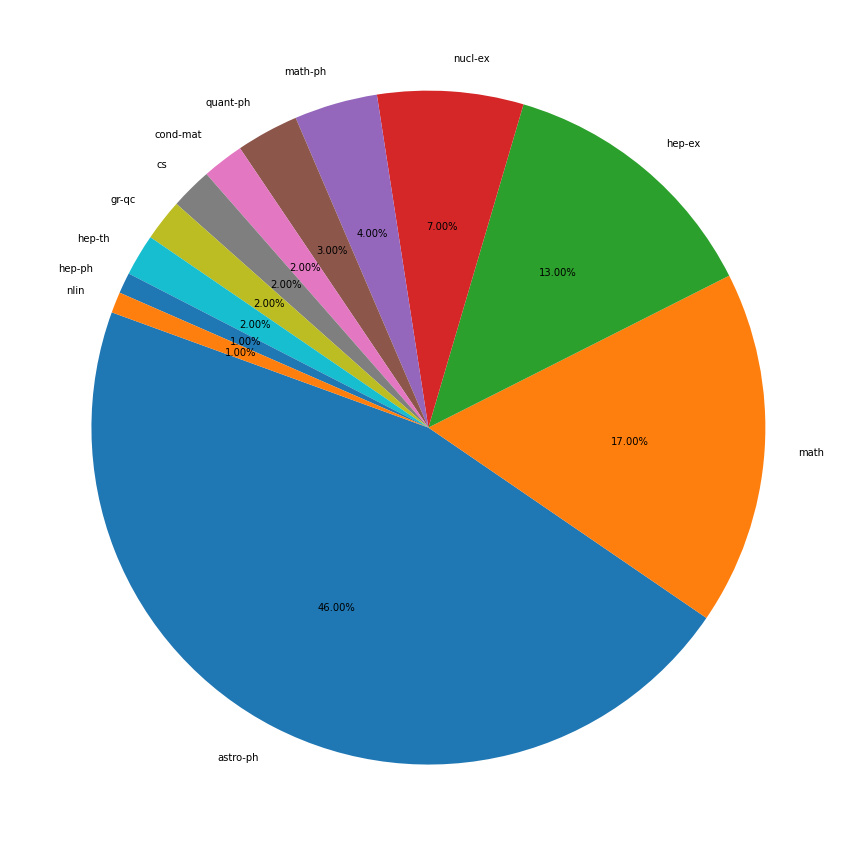

In [20]:
fig = plt.figure(figsize=(15,12))
plt.pie(df2["sum"],  labels=df2["categories"], autopct='%1.2f%%', startangle=160)
plt.tight_layout()
plt.show()